# Validation: compare $m_{4\ell}$ distribution from MCFM `nplotter.f` vs `events.csv`

The MCFM only supports an internal mechanism to produce distributions of observable(s):

1. Compute a (user-defined) observable as a function of the parton kinematics & process matrix element(s).
2. This quantity is filled for each event that populates the MC phase space integration with a weight that takes into account the matrix element squared and the sampling frequency of the phase space region.

When this is being performed, a custom routine was written by me to instead write out the parton kinematics and weight value to a `.csv` file.
This naiive implementation only works in single-threaded mode, of course, as otherwise the lines become mangled from multiple threads.

Anyway, we should expect that this, in principle, allows us to not only reproduce all the physics results already available by MCFM, but also use the per-event record as a "partonic process sample" with which to do unbinned studies (e.g. SBI) with.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

1.5546027
[  5.  15.  25.  35.  45.  55.  65.  75.  85.  95. 105. 115. 125. 135.
 145. 155. 165. 175. 185. 195. 205. 215. 225. 235. 245. 255. 265. 275.
 285. 295. 305. 315. 325. 335. 345. 355. 365. 375. 385. 395. 405. 415.
 425. 435. 445. 455. 465. 475. 485. 495.]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.10377775 0.16335588 0.16016583 0.14624482 0.1296764  0.11282885
 0.09715796 0.083334   0.07110541 0.06100327 0.05191357 0.04457066
 0.03820074 0.03297307 0.0279354  0.02449124 0.02077455 0.01831825
 0.01595633 0.01450756 0.01272856 0.01157471 0.01011655 0.00928262
 0.00836868 0.0075246  0.00677649 0.00632432 0.00540512 0.00494712
 0.0044721  0.0042029 ]


/tmp/ipykernel_26489/1578988591.py:43: RuntimeWarning: invalid value encountered in divide
  ratio = events_vals / nplotter_vals
/tmp/ipykernel_26489/1578988591.py:44: RuntimeWarning: invalid value encountered in divide
  ax2.fill_between(nplotter_xcenters, (nplotter_vals-nplotter_errs)/nplotter_vals, (nplotter_vals+nplotter_errs)/nplotter_vals, step='mid', color='black', alpha=0.25)
/tmp/ipykernel_26489/1578988591.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


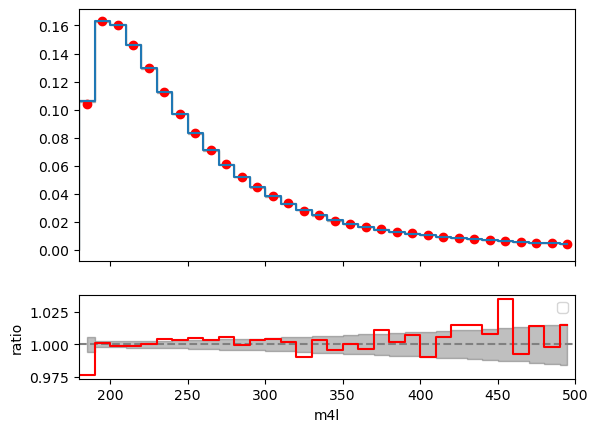

In [6]:
nplotter_txt_filepath = '/raven/u/taepa/mcfm/events/ggZZ2e2m_all/ggZZ4l_lo_NNPDF31_nnlo_as_0118_1.00_1.00_125_ggZZ2e2m_all_m3456.txt'
events_csv_filepath = '/raven/u/taepa/mcfm/events/ggZZ2e2m_all/events.csv'

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
plt.xlim(180,500)

# nplotter
nplotter_data = pd.read_csv(nplotter_txt_filepath, sep='\\s+', comment='#', names=['xmin', 'xmax', 'cross', 'numerror'])
nplotter_xmin = nplotter_data['xmin'].values
nplotter_xmax = nplotter_data['xmax'].values
nplotter_vals = nplotter_data['cross'].values
nplotter_errs = nplotter_data['numerror'].values
nplotter_xcenters = (nplotter_xmin + nplotter_xmax) / 2
nplotter_xbins = np.append(nplotter_xmin,nplotter_xmax[-1])
ax1.fill_between(nplotter_xcenters, nplotter_vals-nplotter_errs, nplotter_vals+nplotter_errs, step='mid', color='black', alpha=0.25)
ax1.step(nplotter_xcenters, nplotter_vals, where='mid', label='nplotter')

mcfm_xsec = 1.5546027
print(mcfm_xsec)

# events
from physics.hstar import gghzz
from physics.simulation import msq
sample = gghzz.Process(
  (mcfm_xsec,events_csv_filepath)
)
events = sample[msq.Component.SBI]
kinematics = events.kinematics
weights = events.weights
def sum_over_4l(kinematics, quantity):
    return np.sum(np.array([kinematics[f'p{lepton}_{quantity}'].to_numpy() for lepton in range(3,7)]), axis=0)
kinematics['m4l'] = np.sqrt(sum_over_4l(kinematics, 'E')**2 - sum_over_4l(kinematics,'px')**2- sum_over_4l(kinematics,'py')**2 - sum_over_4l(kinematics,'pz')**2)

# plot as markers
events_vals, _ = np.histogram(kinematics['m4l'].to_numpy(), bins=nplotter_xbins, weights=weights)
ax1.scatter(nplotter_xcenters, events_vals, label='events', color='red', marker='o')

print(nplotter_xcenters)
print(events_vals)

# ratio
ratio = events_vals / nplotter_vals
ax2.fill_between(nplotter_xcenters, (nplotter_vals-nplotter_errs)/nplotter_vals, (nplotter_vals+nplotter_errs)/nplotter_vals, step='mid', color='black', alpha=0.25)
ax2.axhline(1, color='gray', linestyle='--')
ax2.step(nplotter_xcenters, ratio, where='mid', color='red')
ax2.set_ylabel('ratio')
ax2.set_xlabel('m4l')

plt.legend()
plt.show()

Okay, so the agreement is close, but not perfect (when it was expected to be). Certainly well within MCFM uncertainty (except for first bin?). We should follow up with MCFM author why a discrepancy is occuring between MCFM-internal vs. third-party histogramming code.

In [3]:
for proc, events in samples.items():
  events['4l_E'] = np.sum([events[f'p{i}_E'] for i in range(3,7)], axis=0)
  events['4l_px'] = np.sum([events[f'p{i}_px'] for i in range(3,7)], axis=0)
  events['4l_py'] = np.sum([events[f'p{i}_py'] for i in range(3,7)], axis=0)
  events['4l_pz'] = np.sum([events[f'p{i}_pz'] for i in range(3,7)], axis=0)
  events['4l_m'] = np.sqrt(events['4l_E']**2 - events['4l_px']**2 - events['4l_py']**2 - events['4l_pz']**2)

events_tot = samples['ggZZ_all']
events_bkg = samples['ggZZ_box']
events_hpi = samples['gghZZ_hpi']
events_int = samples['gghZZ_int']

m4l_bins = np.linspace(180,1000,120)
tot_entries, _ = np.histogram(events_tot['4l_m'], bins=m4l_bins, weights=events_tot['wt_norm'])
bkg_entries, _ = np.histogram(events_bkg['4l_m'], bins=m4l_bins, weights=events_bkg['wt_norm'])
hpi_entries, _ = np.histogram(events_hpi['4l_m'], bins=m4l_bins, weights=events_hpi['wt_norm'])
int_entries, _ = np.histogram(events_int['4l_m'], bins=m4l_bins, weights=events_int['wt_norm'])

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8), sharex=True)

ax1.stairs(tot_entries, m4l_bins, color='black', label='$|\mathcal{M}_{ZZ} + \mathcal{M}_h|^2$')
ax1.stairs(bkg_entries, m4l_bins, color='blue', linestyle='dashed', label='$|\mathcal{M}_{ZZ}|^2$')
ax1.stairs(hpi_entries-int_entries, m4l_bins, color='green', linestyle='dashed', label='$|\mathcal{M}_h|^2$')
ax1.stairs(int_entries, m4l_bins, color='orange', linestyle='dashed', label='$2\mathrm{Re}(\mathcal{M}_{ZZ}^{\dag}\mathcal{M}_{h})$')
ax1.stairs(bkg_entries+hpi_entries, m4l_bins, color='red', linestyle='solid', label='$|\mathcal{M}_{ZZ}|^2 + |\mathcal{M}_h|^2 + 2\mathrm{Re}(\mathcal{M}_{ZZ}^{\dag}\mathcal{M}_{h})$')
ax1.legend()
ax1.set_xlim(180,1000)
# ax1.set_ylim(1e-5, np.max(bkg_entries)*2)

ax2.plot(m4l_bins, np.ones_like(m4l_bins), color='black', linestyle='-')
ax2.stairs((bkg_entries+hpi_entries) / tot_entries, m4l_bins, color='red', linestyle='solid')
ax2.set_xscale('log')
ax2.set_ylim(0.9,1.1)
ax2.set_ylabel('$\\frac{|\mathcal{M}_{ZZ}|^2 + |\mathcal{M}_h|^2 + 2\mathrm{Re}(\mathcal{M}_{ZZ}^{\dag}\mathcal{M}_{h})}{|\mathcal{M}_{ZZ} + \mathcal{M}_h|^2}$')
ax2.set_xlabel("$m_{4\ell}$ [GeV]")

plt.tight_layout()
plt.show()

<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_26489/1232408866.py:21: SyntaxWarning: invalid escape sequence '\m'
  ax1.stairs(tot_entries, m4l_bins, color='black', label='$|\mathcal{M}_{ZZ} + \mathcal{M}_h|^2$')
/tmp/ipykernel_26489/1232408866.py:22: SyntaxWarning: invalid escape sequence '\m'
  ax1.stairs(bkg_entr

NameError: name 'samples' is not defined